In [1]:
import sys
sys.path.insert(0,'/mnt/DATA/coding/LIM/')
from lim import lim as L
from lim import LineModel
from astropy import units as u
import matplotlib as mpl
import numpy as np 
import matplotlib.pyplot as plt
import zeus21
from zeus21 import LIM
from scipy.interpolate import interp1d

#set up the CLASS cosmology
from classy import Class
ClassCosmo = Class()
ClassCosmo.compute()

In [2]:
plt.rcParams.update({"text.usetex": True, "font.family": "Times new roman"}) # Use latex fonts
plt.rcParams['lines.linewidth'] = 2
colors = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6', '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) # Set the color palette as default

In [3]:
zObs=10.

In [4]:
# shared parameters between zeus21 and LIM
# cosmology
CosmoParams_input = zeus21.Cosmo_Parameters_Input()
ClassyCosmo = zeus21.runclass(CosmoParams_input)
CosmoParams = zeus21.Cosmo_Parameters(CosmoParams_input, ClassyCosmo) 
HMF_interpolator = zeus21.HMF_interpolator(CosmoParams,ClassyCosmo)
# astrophysics
AstroParams = zeus21.Astro_Parameters(CosmoParams)

LineParams_input = zeus21.LineParams_Input(\
                 LINE = 'CII',
                 OBSERVABLE_LIM = 'Tnu',
                 _R = 3., # for now we consider radius larger than NL level 
                 CII_MODEL = 'Lagache18',
                 CII_nu_rest = 1.897e12, 
                 CII_alpha_SFR_0 = 1.4-0.07*10,
                 CII_alpha_SFR_z = 0.,
                 CII_beta_SFR_0 = 7.1-0.07*10,
                 CII_beta_SFR_z = 0.,
                 CII_sigma_LSFR = 0.5)
LineParams = zeus21.Line_Parameters(LineParams_input) 

# CII line
nu=LineParams.CII_nu_rest*u.Hz
alpha_CII_0 = LineParams.CII_alpha_SFR_0
alpha_CII_z = LineParams.CII_alpha_SFR_z
beta_CII_0 = LineParams.CII_beta_SFR_0
beta_CII_z = LineParams.CII_beta_SFR_z


In [5]:
input_params = dict(cosmo_code ='class',
                     cosmo_input_class=dict(f_NL=0,
                       H0=CosmoParams.h_fid*100.,omega_b=CosmoParams.omegab, omega_cdm=CosmoParams.omegac, 
                A_s=CosmoParams.As,n_s=CosmoParams.ns,
                #N_ncdm=3, m_ncdm='0.02,0.02,0.02', N_ur = 0.00641, USE DEFAULT FROM CLASS
                output='mPk,mTk'))

astro_params = dict(model_type='ML', # use mass-luminosity relation
                 model_name='CII_zeus21', 
                 model_par={'alpha_CII_0':alpha_CII_0,
                 'alpha_CII_z':alpha_CII_z, 'beta_CII_0':beta_CII_0,'beta_CII_z':beta_CII_z,
                 'Cosmo_Parameters':CosmoParams,
                 'HMF_interpolator':HMF_interpolator,
                 'Astro_Parameters':AstroParams
                 },
                 hmf_model='ST',
                 bias_model='ST99',
                 bias_par={}, #Otherwise, write a dict with the corresponding values
                 nu=nu,
                 nuObs=nu/(1+zObs),
                 Mmin=1e8*u.Msun,
                 Mmax=1e14*u.Msun,
                 nM=500,
                 Lmin=10*u.Lsun,
                 Lmax=1e8*u.Lsun,
                 nL=5000,
                 v_of_M=None, # to apply line width
                 line_incli=False,) # account for randomly inclined line profiles

pk_params = dict(kmin = 1e-2*u.Mpc**-1, # in the line power spectrum
                 kmax = CosmoParams.kmax_CLASS*u.Mpc**-1, # in the line power spectrum
                 nk = 100,
                 k_kind = 'log',
                 sigma_scatter=0., # scatter in the mass-luminosity relation
                 fduty=1.,
                 do_onehalo=True, # testing linear for now
                 do_Jysr=False,
                 do_RSD=False, # testing without RSD for now
                 sigma_NL=7*u.Mpc, # scale for non linearities in FoG
                 nmu=1000,
                 FoG_damp='Lorentzian',
                 smooth=False,
                 do_conv_Wkmin = False,
                 nonlinear=False,) # using the non linear matter power spectrum in PKint

input_params.update(astro_params)
input_params.update(pk_params)

In [6]:
ll = L(input_params)

##### 1) Matter power spectrum

Text(0, 0.5, '$P_m(k,z=10) [{\\rm Mpc}^3]$')

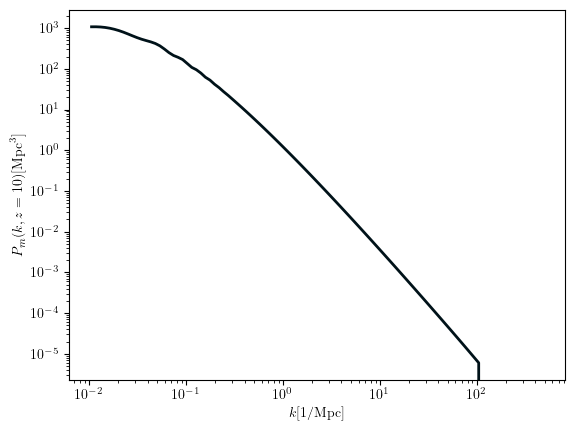

In [7]:
k = ll.k 
Pm = ll.PKint(k,np.array([zObs]),len(k),1,0)*u.Mpc**3

plt.loglog(k,Pm)
plt.xlabel(r'$k [1/{\rm Mpc}]$')
plt.ylabel(r'$P_m(k,z=%g) [{\rm Mpc}^3]$'%zObs)

### 2) Line power spectrum

First of all, we consider the two halo term without RSD and without shot noise:

$P_{\rm CII}(k,z)=\bar{T}^2b_{avg}^2P_m(k,z)$

In [8]:
print('bar_T =' + str(ll.Tmean))
print('b_avg =' + str(ll.bavg[0]))
print('bar_T * b_avg = ' + str(ll.Tmean * ll.bavg[0]))

bar_T =0.04851202959746356 uK
b_avg =4.199514114375503
bar_T * b_avg = 0.20372695301155036 uK


Text(0, 0.5, '$W_{R_0}(k,z =10)$')

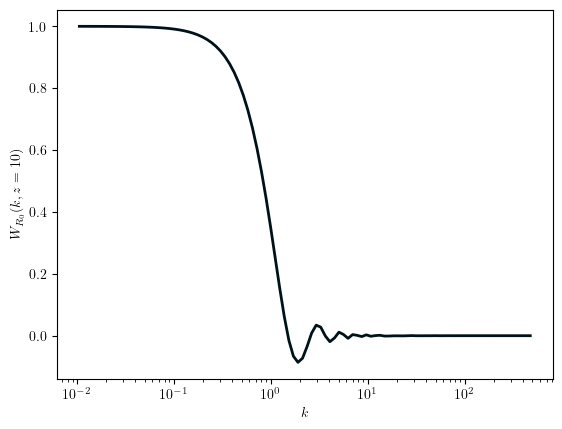

In [9]:
R = LineParams._R * u.Mpc
x = (k*R).value
window = 3.0*(np.sin(x) - x*np.cos(x))/(x)**3 

plt.semilogx(k,window)
plt.xlabel(r'$k$')
plt.ylabel(r'$W_{R_0}(k,z =10)$')

(1e-05, 100.0)

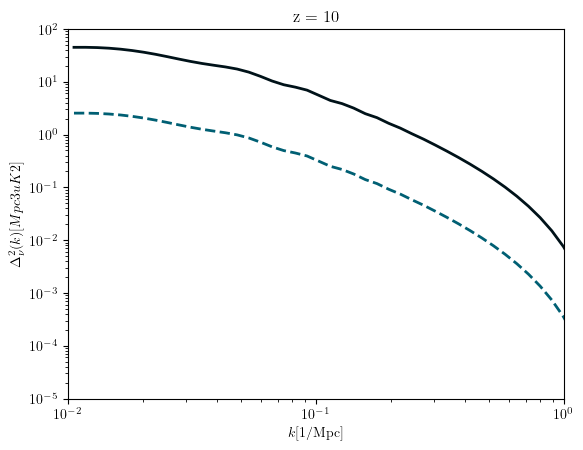

In [10]:
PLIM_analytical = (window**2 * ll.Pk_clust[0]) #* k**3 / 2/np.pi**2 # fixing the index in mu
PLIM_NL_analytical = (window**2 * ll.Pk_clust[0]) #* k**3 / 2/np.pi**2 # fixing the index in mu

plt.loglog(k,PLIM_analytical)
plt.loglog(k,Pm*(window*ll.Tmean)**2,'--')
plt.xlabel(r'$k [1/{\rm Mpc}]$')
plt.ylabel(r'$\Delta^2_\nu(k) [%s]$'%PLIM_analytical.unit)
plt.title('z = %g'%zObs)
plt.xlim(1e-2,1e0)
plt.ylim(1e-5,1e2)